# Modeling

This notebook uses a wide variety of modeling algorithms for a binary classification problem. It reads a file created from a feature selection process that has a reasonably small number of good variables, and we know their order of multivariate importance because we used a proper wrapper method. We can explore # input variables, model algorithms and tune model hyperparameters. At the end we can select our favorite algorithm, run it again and build the final model performace score percentile tables.

Here we call the larger fraction population the goods and the smaller fraction the bads. This notebook was originally
written for fraud detection but can be used for any binary classification. It uses detection rate as an appropriate measure of goodness.

Rather than use a built-in CV, we do a "manual CV" by running each model multiple (nitermax) times and average the performance on the training (trn), testing (tst) and out of time (oot) data sets.

Some of the ML algorithms are very fast and some are slow. Feel free to comment out any cells/models you want. At the bottom of the notebook you can select your final model/hyperparameters to run one time only and then make the business perfoemance tables for that final model.

Things to add: better calculation of FDR@3% when building a model using sampled training data. Right now I just approximate it by using the entire population trntst for a model built with sampled data.

In [1]:
from datetime import datetime
start_time = datetime.now()

import pandas as pd
import random
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
import gc
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
%%time
vars = pd.read_csv('vars_final.csv')
print(vars.shape)
vars.head()

(97496, 22)
CPU times: total: 62.5 ms
Wall time: 130 ms


,Cardnum_unique_count_for_card_state_1,card_merch_total_3,card_state_max_14,Card_dow_vdratio_0by14,Card_dow_unique_count_for_Card_Merchdesc_1,Merchnum_total_7,state_des_total_1,Card_dow_unique_count_for_state_des_1,card_state_total_7,Cardnum_total_60,...,merch_state_total_7,Cardnum_day_since,card_zip_max_7,Cardnum_total_30,Card_dow_unique_count_for_merch_zip_14,Merchnum_desc_total_7,Card_dow_day_since,merch_state_total_0,Recnum,Fraud
0,1,3.62,3.62,0.000049,1,3.62,3.62,1,3.62,3.62,...,3.62,1461.0,3.62,3.62,1,3.62,1461.0,3.62,1,0
1,1,31.42,31.42,0.000049,1,31.42,31.42,1,31.42,31.42,...,31.42,1461.0,31.42,31.42,1,31.42,1461.0,31.42,2,0
2,1,178.49,178.49,0.000049,1,178.49,178.49,1,178.49,178.49,...,178.49,1461.0,178.49,178.49,1,178.49,1461.0,178.49,3,0
3,1,3.62,3.62,0.000049,1,7.24,3.62,1,3.62,3.62,...,7.24,1461.0,3.62,3.62,1,3.62,1461.0,7.24,4,0
4,1,7.24,3.62,0.071429,1,10.86,7.24,1,7.24,7.24,...,10.86,0.0,3.62,7.24,1,7.24,0.0,10.86,5,0


In [3]:
# set the number of variables desired here, and set the names of the y and record number properly
NVARS = 10

# vars.rename(columns={'record':'Recnum'},inplace=True)
# vars.rename(columns={'fraud_label':'Fraud'},inplace=True)
detect_rate = .03
numvars = min(NVARS,len(vars)-2)
final_vars_list = ['Recnum','Fraud']
for i in range(numvars):
    final_vars_list.append(vars.columns[i])
    
final_vars_list

['Recnum',
 'Fraud',
 'Cardnum_unique_count_for_card_state_1',
 'card_merch_total_3',
 'card_state_max_14',
 'Card_dow_vdratio_0by14',
 'Card_dow_unique_count_for_Card_Merchdesc_1',
 'Merchnum_total_7',
 'state_des_total_1',
 'Card_dow_unique_count_for_state_des_1',
 'card_state_total_7',
 'Cardnum_total_60']

In [4]:
vars = vars.filter(final_vars_list,axis=1)
vars.head()

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,card_merch_total_3,card_state_max_14,Card_dow_vdratio_0by14,Card_dow_unique_count_for_Card_Merchdesc_1,Merchnum_total_7,state_des_total_1,Card_dow_unique_count_for_state_des_1,card_state_total_7,Cardnum_total_60
0,1,0,1,3.62,3.62,0.000049,1,3.62,3.62,1,3.62,3.62
1,2,0,1,31.42,31.42,0.000049,1,31.42,31.42,1,31.42,31.42
2,3,0,1,178.49,178.49,0.000049,1,178.49,178.49,1,178.49,178.49
3,4,0,1,3.62,3.62,0.000049,1,7.24,3.62,1,3.62,3.62
4,5,0,1,7.24,3.62,0.071429,1,10.86,7.24,1,7.24,7.24


In [5]:
vars.shape

(97496, 12)

In [6]:
vars['Fraud'].sum()

2047

In [7]:
print("fraud rate in data is",vars['Fraud'].sum()/len(vars))

fraud rate in data is 0.020995733158283417


In [8]:
vars.head(10)

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,card_merch_total_3,card_state_max_14,Card_dow_vdratio_0by14,Card_dow_unique_count_for_Card_Merchdesc_1,Merchnum_total_7,state_des_total_1,Card_dow_unique_count_for_state_des_1,card_state_total_7,Cardnum_total_60
0,1,0,1,3.62,3.62,0.000049,1,3.62,3.62,1,3.62,3.62
1,2,0,1,31.42,31.42,0.000049,1,31.42,31.42,1,31.42,31.42
2,3,0,1,178.49,178.49,0.000049,1,178.49,178.49,1,178.49,178.49
3,4,0,1,3.62,3.62,0.000049,1,7.24,3.62,1,3.62,3.62
4,5,0,1,7.24,3.62,0.071429,1,10.86,7.24,1,7.24,7.24
5,6,0,1,3.67,3.67,0.000049,1,14.53,3.67,1,3.67,3.67
6,7,0,1,3.62,3.62,0.000049,1,18.15,7.24,1,3.62,3.62
7,8,0,1,230.32,230.32,0.000049,1,230.32,230.32,1,230.32,230.32
8,9,0,1,62.11,62.11,0.000049,1,62.11,62.11,1,62.11,62.11
9,10,0,1,10.86,3.62,0.071429,1,21.77,10.86,1,10.86,10.86


In [9]:
vars.shape

(97496, 12)

In [10]:
vars.describe()

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,card_merch_total_3,card_state_max_14,Card_dow_vdratio_0by14,Card_dow_unique_count_for_Card_Merchdesc_1,Merchnum_total_7,state_des_total_1,Card_dow_unique_count_for_state_des_1,card_state_total_7,Cardnum_total_60
count,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000
mean,48915.137247,0.020996,1.724266,626.489281,603.535848,0.020482,1.571193,2640.524416,1080.068475,1.571264,899.277143,11863.786013
std,28262.212670,0.143371,1.568565,4040.113444,1194.174516,0.026914,1.882741,6291.884831,4397.448150,1.882744,4224.891618,24806.437709
min,1.000000,0.000000,1.000000,0.010000,0.010000,0.000039,1.000000,0.010000,0.010000,1.000000,0.010000,0.170000
25%,24428.750000,0.000000,1.000000,55.000000,67.187500,0.001587,1.000000,213.135000,84.650000,1.000000,87.595000,2157.707500
50%,48916.000000,0.000000,1.000000,178.805000,258.885000,0.002976,1.000000,944.435000,295.000000,1.000000,280.800000,5732.175000
75%,73402.250000,0.000000,2.000000,540.000000,729.900000,0.042857,2.000000,3101.160000,1015.560000,2.000000,835.312500,13216.455000
max,97852.000000,1.000000,21.000000,306633.410000,47900.000000,0.071429,38.000000,313984.550000,306633.410000,38.000000,306633.410000,519334.990000


In [11]:
# find the row i vars that corresponds to 11/1 for the oot
test = vars[vars['Recnum'] > 85264]
test.head(10)

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,card_merch_total_3,card_state_max_14,Card_dow_vdratio_0by14,Card_dow_unique_count_for_Card_Merchdesc_1,Merchnum_total_7,state_des_total_1,Card_dow_unique_count_for_state_des_1,card_state_total_7,Cardnum_total_60
84935,85265,0,1,174.61,225.00,0.000317,1,1430.61,174.61,1,174.61,399.61
84936,85266,0,1,53.00,206.90,0.001190,1,53.00,53.00,1,259.90,9597.22
84937,85267,0,1,25.00,531.25,0.002976,1,25.00,25.00,1,25.00,3603.74
84938,85268,0,1,97.17,97.17,0.001661,1,97.17,97.17,1,97.17,5097.63
84939,85269,0,1,6.51,6.51,0.001429,1,26.52,6.51,1,6.51,35.20
84940,85270,0,1,170.00,170.00,0.001116,1,170.00,170.00,1,170.00,1893.62
84941,85271,0,1,250.00,250.00,0.001786,1,285.92,250.00,1,263.71,13984.35
84942,85272,0,1,15.00,15.00,0.001429,1,45.00,15.00,1,15.00,2101.00
84943,85273,0,1,300.00,2105.00,0.001984,1,300.00,300.00,1,2895.00,27305.45
84944,85274,0,1,133.20,97.02,0.004464,1,504.47,97.02,1,133.20,3037.91


In [12]:
record_save = vars['Recnum']
Y_save = pd.DataFrame(vars.loc[:,'Fraud'])
Y_save.head()

,Fraud
0,0
1,0
2,0
3,0
4,0


## Scale and truncate field values

In [13]:
X_no_scaling = vars.drop(columns = ['Recnum','Fraud'])
X_no_scaling.describe()

,Cardnum_unique_count_for_card_state_1,card_merch_total_3,card_state_max_14,Card_dow_vdratio_0by14,Card_dow_unique_count_for_Card_Merchdesc_1,Merchnum_total_7,state_des_total_1,Card_dow_unique_count_for_state_des_1,card_state_total_7,Cardnum_total_60
count,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000
mean,1.724266,626.489281,603.535848,0.020482,1.571193,2640.524416,1080.068475,1.571264,899.277143,11863.786013
std,1.568565,4040.113444,1194.174516,0.026914,1.882741,6291.884831,4397.448150,1.882744,4224.891618,24806.437709
min,1.000000,0.010000,0.010000,0.000039,1.000000,0.010000,0.010000,1.000000,0.010000,0.170000
25%,1.000000,55.000000,67.187500,0.001587,1.000000,213.135000,84.650000,1.000000,87.595000,2157.707500
50%,1.000000,178.805000,258.885000,0.002976,1.000000,944.435000,295.000000,1.000000,280.800000,5732.175000
75%,2.000000,540.000000,729.900000,0.042857,2.000000,3101.160000,1015.560000,2.000000,835.312500,13216.455000
max,21.000000,306633.410000,47900.000000,0.071429,38.000000,313984.550000,306633.410000,38.000000,306633.410000,519334.990000


In [14]:
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

In [15]:
# use this to cap variables. For some problems it helps
Clip = 10

In [16]:
# push in any outlier values, then rescale
X.clip(-1*Clip,Clip,inplace=True)
X = (X - X.mean()) / X.std()
X.describe()

,Cardnum_unique_count_for_card_state_1,card_merch_total_3,card_state_max_14,Card_dow_vdratio_0by14,Card_dow_unique_count_for_Card_Merchdesc_1,Merchnum_total_7,state_des_total_1,Card_dow_unique_count_for_state_des_1,card_state_total_7,Cardnum_total_60
count,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04
mean,1.049460e-17,1.166067e-18,-3.439897e-17,1.224370e-17,2.973470e-17,-1.166067e-17,-5.247300e-18,1.982313e-17,8.453983e-18,8.162467e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.651796e-01,-3.198925e-01,-6.218751e-01,-7.595529e-01,-3.208247e-01,-5.698225e-01,-4.088849e-01,-3.208649e-01,-3.879782e-01,-5.497828e-01
25%,-4.651796e-01,-2.893305e-01,-5.510254e-01,-7.020303e-01,-3.208247e-01,-5.227246e-01,-3.752926e-01,-3.208649e-01,-3.479317e-01,-4.476115e-01
50%,-4.651796e-01,-2.205227e-01,-3.488489e-01,-6.504263e-01,-3.208247e-01,-3.611170e-01,-2.918079e-01,-3.208649e-01,-2.595926e-01,-2.783406e-01
75%,1.782986e-01,-1.977959e-02,1.479138e-01,8.313456e-01,2.516598e-01,1.154908e-01,-5.828940e-03,2.516177e-01,-6.052943e-03,7.608159e-02
max,1.009425e+01,2.248223e+01,1.260917e+01,1.892914e+00,1.078457e+01,1.391793e+01,1.747256e+01,1.078456e+01,1.934066e+01,1.175925e+01


In [17]:
# separate data into modeling (traintest) and out of time. Here I'm using the record number to do this separation.
# you need to change this oot record number to whatever is appropriate for your data
oot_recnum = 85264
X_trntst = X[0:oot_recnum]
Y_trntst = Y_save[0:oot_recnum]
X_oot = X[oot_recnum:]
Y_oot = Y_save[oot_recnum:]
Y_oot.sum()

Fraud    297
dtype: int64

## Look at PCA

In [18]:
len(X_trntst.columns)

10

In [19]:
X_trntst_save = X_trntst.copy()

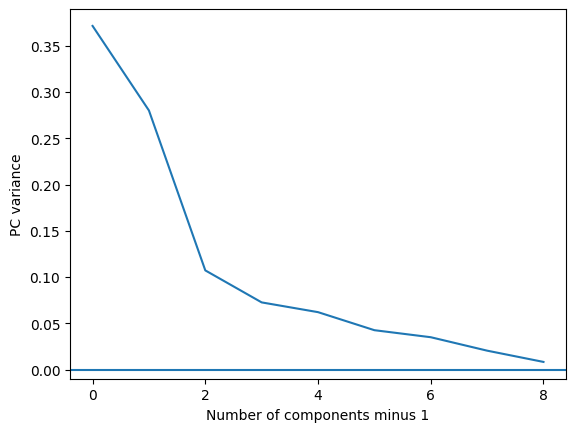

In [20]:
pca = PCA(n_components = .999, svd_solver = 'full')
pca.fit(X_trntst)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, len(X_trntst.columns), step=2))
plt.axhline(y=0,xmin=0,xmax=len(X_trntst.columns))
X_trntst = X_trntst_save.copy()

In [21]:
# We look at the above picture, select how many PCs we want to keep, and then redo the PCA with just this many PCs
pca = PCA(n_components = 4, svd_solver = 'full')
princ_comps = pca.fit_transform(X_trntst)
X_trntst_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
X_trntst_pca.head()

,PC1,PC2,PC3,PC4
0,-1.305320,-0.615550,0.009016,0.192539
1,-1.273785,-0.623111,0.015589,0.187698
2,-1.106956,-0.663113,0.050358,0.162087
3,-1.305037,-0.615639,0.008635,0.192884
4,-1.018539,0.223885,-0.792664,-1.770437


In [22]:
princ_comps = pca.transform(X_oot)
X_oot_orig_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)],index=X_oot.index)
X_oot_orig_pca.head()

,PC1,PC2,PC3,PC4
85264,-0.647823,0.513438,0.233929,0.012891
85265,-0.728895,0.850172,-0.743633,-1.664592
85266,1.708987,-1.376156,-0.207091,0.353746
85267,-0.878748,-0.323562,0.402632,0.327221
85268,-0.305391,-0.800342,0.051199,0.276774


In [23]:
X_trntst.describe()

,Cardnum_unique_count_for_card_state_1,card_merch_total_3,card_state_max_14,Card_dow_vdratio_0by14,Card_dow_unique_count_for_Card_Merchdesc_1,Merchnum_total_7,state_des_total_1,Card_dow_unique_count_for_state_des_1,card_state_total_7,Cardnum_total_60
count,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000
mean,0.004006,0.001557,0.002218,0.003494,0.010628,0.018205,0.008068,0.010634,0.001197,-0.000627
std,1.007299,1.015560,1.007176,1.000623,1.030808,1.030251,1.034248,1.030808,1.011980,0.983413
min,-0.465180,-0.319893,-0.621875,-0.759504,-0.320825,-0.569822,-0.408885,-0.320865,-0.387978,-0.549783
25%,-0.465180,-0.289747,-0.553332,-0.699287,-0.320825,-0.521327,-0.375548,-0.320865,-0.348251,-0.449464
50%,-0.465180,-0.221115,-0.350594,-0.640374,-0.320825,-0.348838,-0.293076,-0.320865,-0.259542,-0.278097
75%,0.178299,-0.019780,0.152238,0.831346,0.251660,0.141757,-0.004482,0.251618,-0.006179,0.081328
max,10.094246,22.482230,12.609173,1.892914,10.784575,13.917932,17.472558,10.784555,19.340660,11.759250


In [24]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,12232.000000,12232.000000,12232.000000,12232.000000
mean,-0.120605,-0.089195,0.101177,-0.073573
std,1.630913,1.390377,1.001458,0.812146
min,-1.304935,-8.579535,-6.807798,-7.179034
25%,-0.943665,-0.689248,-0.317107,-0.375825
50%,-0.542380,-0.588254,0.077008,0.123613
75%,0.172925,0.197584,0.354342,0.287714
max,37.596206,17.292780,14.156341,5.354009


In [25]:
# zscale the PCs
mean = X_trntst_pca.mean()
stdev = X_trntst_pca.std()
X_trntst_pca = (X_trntst_pca - mean)/stdev
X_oot_orig_pca = (X_oot_orig_pca - mean)/stdev

In [26]:
X_trntst_pca.describe()

,PC1,PC2,PC3,PC4
count,8.526400e+04,8.526400e+04,8.526400e+04,8.526400e+04
mean,2.700036e-17,-5.333404e-18,-4.000053e-18,1.041680e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-6.690415e-01,-5.956284e+00,-1.184685e+01,-7.493429e+00
25%,-4.596718e-01,-4.099222e-01,-4.326567e-01,-3.993885e-01
50%,-2.551916e-01,-3.388786e-01,4.551853e-02,1.535462e-01
75%,1.468293e-01,2.238730e-01,3.317414e-01,4.096491e-01
max,2.041640e+01,1.068461e+01,1.335859e+01,1.129827e+01


In [27]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,12232.000000,12232.000000,12232.000000,12232.000000
mean,-0.061631,-0.052494,0.096225,-0.085010
std,0.833424,0.818272,0.952440,0.938399
min,-0.666844,-5.049275,-6.474574,-8.295055
25%,-0.482229,-0.405640,-0.301586,-0.434249
50%,-0.277166,-0.346202,0.073239,0.142829
75%,0.088368,0.116283,0.336998,0.332441
max,19.212305,10.177241,13.463425,6.186320


In [28]:
X_trntst_pca.shape

(85264, 4)

In [29]:
X_oot_orig_pca.shape

(12232, 4)

## Subsample the larger class if desired

In [30]:
# set the ratio of goods to bads that you would like. This next line is the ratio of goods to bads that you want for modeling
sample_ratio_desired = 1

temp = X_trntst.copy()
temp['Fraud'] = Y_trntst['Fraud']
temp.head()
goods = temp[temp['Fraud']==0]
bads = temp[temp['Fraud']==1]
actual_bad_fraction = len(bads)/len(temp)
actual_good_fraction = 1 - actual_bad_fraction
print(actual_bad_fraction)
fraction = sample_ratio_desired * actual_bad_fraction
goods_sampled = goods.sample(frac = fraction)
all_sampled = pd.concat([goods_sampled,bads])
all_sampled.sort_index(inplace=True)
Y_trntst_sampled = pd.DataFrame(all_sampled['Fraud'])
X_trntst_sampled = all_sampled.drop(columns=['Fraud'])
del [temp,goods,bads,all_sampled]
gc.collect()
print(X_trntst_sampled.shape,len(Y_trntst_sampled))

0.020524488647025708
(3464, 10) 3464


In [31]:
niter = 0
nitermax = 10
jittersize = .1
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

## Models

You can comment in/out any of these model cells and just explore one model type. You can also just rerun that single cell multiple times (hit shift-enter on that cell) as you manually explore different model hyperparameters.

In [33]:
Modeling_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(1000))
counter = 0
model_counter = 0

In [34]:
%%time
# Logistic regression

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = LogisticRegression(penalty = 'l2', C = 1, solver = 'liblinear')
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['log reg',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 0.6729508196721311 0.7075471698113207 0.5286195286195287
1 0.6858333333333333 0.6927272727272727 0.5286195286195287
2 0.6914095079232694 0.6715063520871143 0.5353535353535354
3 0.6994171523730225 0.6703096539162113 0.5252525252525253
4 0.6933010492332526 0.6771037181996086 0.5252525252525253
5 0.6978998384491115 0.666015625 0.5252525252525253
6 0.6720475785896347 0.7085514834205934 0.5252525252525253
7 0.6895161290322581 0.6823529411764706 0.5252525252525253
8 0.6874493927125506 0.6776699029126214 0.5218855218855218
9 0.6920583468395461 0.6782945736434108 0.5252525252525253
trn    0.688188
tst    0.683208
oot    0.526599
dtype: float64
CPU times: total: 281 ms
Wall time: 952 ms


In [63]:
%%time
# Single DT

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = DecisionTreeClassifier(criterion = 'gini', max_depth = 8, min_samples_split = 120, min_samples_leaf = 60)
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['DT',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1

print(FDR.mean())
model_counter = model_counter + 1

0 0.731404958677686 0.6796296296296296 0.5387205387205387
1 0.7437145174371452 0.7330754352030948 0.5656565656565656
2 0.7455573505654282 0.75 0.5824915824915825
3 0.7481542247744053 0.7080979284369114 0.5252525252525253
4 0.7512234910277324 0.7041984732824428 0.5286195286195287
5 0.7497900923593619 0.7101967799642218 0.5622895622895623
6 0.7404393816110659 0.72552783109405 0.531986531986532
7 0.7493897477624084 0.7197696737044146 0.5622895622895623
8 0.7483388704318937 0.7307692307692307 0.5892255892255892
9 0.7624584717607974 0.6996336996336996 0.5824915824915825
trn    0.747047
tst    0.716090
oot    0.556902
dtype: float64
CPU times: total: 1.23 s
Wall time: 2.75 s


In [64]:
%%time
# RF

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# Note for students: The default values are a fairly complex architecture and make this cell run slow.
    model = RandomForestClassifier(criterion = 'log_loss', n_estimators =30, max_depth = 8, min_samples_split = 120, min_samples_leaf = 60, max_features = 7, n_jobs = -1)
    
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['RF',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 0.7564308681672026 0.7430830039525692 0.5555555555555556
1 0.7667757774140753 0.740530303030303 0.5521885521885522
2 0.7469975980784628 0.7445109780439122 0.5420875420875421
3 0.7588769611890999 0.7458256029684601 0.5521885521885522
4 0.7668308702791461 0.7406015037593985 0.5420875420875421
5 0.7660961695191524 0.7533460803059273 0.5589225589225589
6 0.7706645056726094 0.7441860465116279 0.5589225589225589
7 0.7483818770226537 0.7723735408560312 0.569023569023569
8 0.763396537510305 0.7318435754189944 0.5521885521885522
9 0.7782324058919804 0.7537878787878788 0.5420875420875421
trn    0.762268
tst    0.747009
oot    0.552525
dtype: float64
CPU times: total: 59.6 s
Wall time: 6.22 s


In [65]:
%%time
# LGBM

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = lgb.LGBMClassifier(max_depth = 3, n_estimators = 100, num_leaves = 5, learning_rate = 0.1, n_jobs = -1)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

[LightGBM] [Info] Number of positive: 1240, number of negative: 58444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 59684, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020776 -> initscore=-3.852958
[LightGBM] [Info] Start training from score -3.852958
0 0.7758064516129032 0.7725490196078432 0.5185185185185185
[LightGBM] [Info] Number of positive: 1215, number of negative: 58469
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train s

In [66]:
%%time
# NN

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
# Note for students: The default values are a fairly complex architecture and make this cell run slow.
    model = MLPClassifier(hidden_layer_sizes=(20,20), solver = 'adam', alpha = 0.005, learning_rate_init = 0.01)
    
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['NN',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 0.7823240589198036 0.7708333333333334 0.5959595959595959
1 0.7966942148760331 0.7703703703703704 0.5656565656565656
2 0.809215844785772 0.7914230019493177 0.6094276094276094
3 0.8049792531120332 0.7688073394495413 0.6127946127946128
4 0.8108108108108109 0.782520325203252 0.5791245791245792
5 0.7978981406628941 0.7816764132553606 0.6026936026936027
6 0.7792642140468228 0.7725631768953068 0.6026936026936027
7 0.8043117744610282 0.7665441176470589 0.5791245791245792
8 0.7903752039151712 0.7938931297709924 0.5723905723905723
9 0.7799163179916317 0.7747747747747747 0.6094276094276094
trn    0.795579
tst    0.777341
oot    0.592929
dtype: float64
CPU times: total: 15 s
Wall time: 42.8 s


## Model comparison plots

In [67]:
df = Modeling_output.dropna()
df.head(20)

,Model,Trn,Tst,OOT
0,log reg,0.692246,0.679688,0.525253
1,log reg,0.684943,0.691288,0.525253
2,log reg,0.682421,0.700368,0.525253
3,log reg,0.680658,0.695327,0.525253
4,log reg,0.691237,0.671078,0.52862
5,log reg,0.682114,0.703846,0.52862
6,log reg,0.689627,0.684109,0.52862
7,log reg,0.68374,0.696154,0.52862
8,log reg,0.695688,0.667946,0.531987
9,log reg,0.701923,0.653386,0.52862


In [68]:
df.shape

(50, 4)

In [69]:
df_unpivot = df.melt( id_vars='Model', value_vars=['Trn','Tst','OOT'], var_name='Type', value_name='Value')
df_unpivot.head()

,Model,Type,Value
0,log reg,Trn,0.692246
1,log reg,Trn,0.684943
2,log reg,Trn,0.682421
3,log reg,Trn,0.680658
4,log reg,Trn,0.691237


In [70]:
df_compare = df_unpivot[(df_unpivot['Type']=='Trn') | (df_unpivot['Type']=='Tst') | (df_unpivot['Type']=='OOT')]
df_compare.head()

,Model,Type,Value
0,log reg,Trn,0.692246
1,log reg,Trn,0.684943
2,log reg,Trn,0.682421
3,log reg,Trn,0.680658
4,log reg,Trn,0.691237


In [71]:
output = df.groupby('Model').agg({'Trn':['mean','std'],'Tst':['mean','std'],'OOT':['mean','std']})
output

Trn                 Tst                 OOT          
             mean       std      mean       std      mean       std
Model                                                              
DT       0.747047  0.007976   0.71609  0.019991  0.556902  0.024134
LGBM     0.782802  0.004723   0.76852  0.009055  0.537374  0.011577
NN       0.795579  0.012035  0.777341  0.009590  0.592929  0.017274
RF       0.762268  0.009741  0.747009  0.010922  0.552525  0.008759
log reg   0.68846  0.006905  0.684319  0.016229  0.527609  0.002273

In [72]:
df.head()

,Model,Trn,Tst,OOT
0,log reg,0.692246,0.679688,0.525253
1,log reg,0.684943,0.691288,0.525253
2,log reg,0.682421,0.700368,0.525253
3,log reg,0.680658,0.695327,0.525253
4,log reg,0.691237,0.671078,0.52862


In [73]:
best_OOT = df['OOT'].max()
best_OOT

0.6127946127946128

C:\Users\josh9\anaconda3\envs\zanis\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\josh9\anaconda3\envs\zanis\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\josh9\anaconda3\envs\zanis\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\josh9\anaconda3\envs\zanis\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.

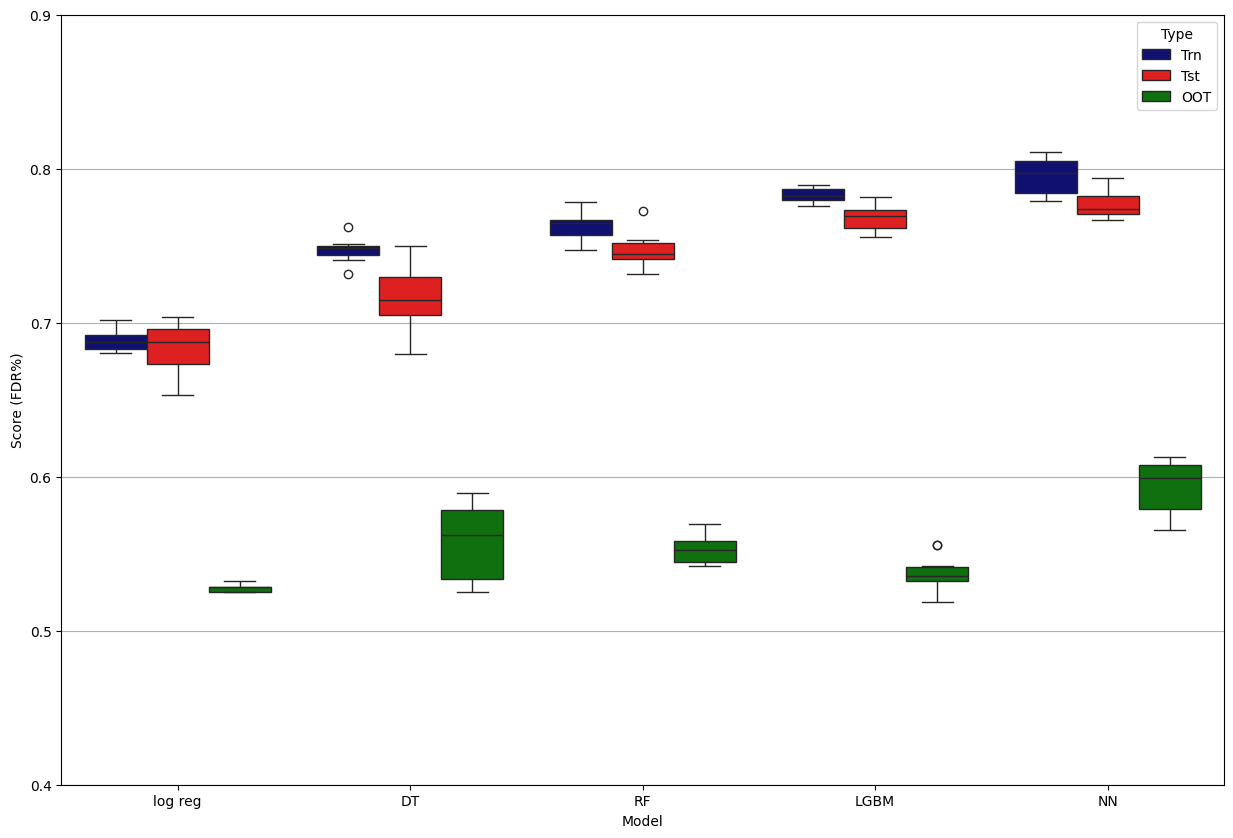

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
ax = sns.boxplot(x='Model',y='Value',hue='Type', data=df_compare, palette=['navy','r','g'])

plt.ylim(.4,.9)
plt.ylabel('Score (FDR%)')
plt.grid(axis='y')
plt.savefig('modeling.png')
plt.show()

In [218]:
print('duration: ', datetime.now() - start_time)

duration:  0:09:53.397380


This next cell can be used to explore overfitting

0 0.7017543859649122 0.7157258064516129 0.5420875420875421
1 0.7043054427294883 0.7052023121387283 0.531986531986532
2 0.7137129109863672 0.6918489065606361 0.5420875420875421
loop trn tst oot 100 0.7065909132269227 0.7042590083836591 0.5387205387205386
0 0.7117973079968329 0.6940451745379876 0.5454545454545454
1 0.7054515866558178 0.7351247600767754 0.5420875420875421
2 0.7072368421052632 0.7209737827715356 0.5420875420875421
loop trn tst oot (100, 100) 0.7081619122526379 0.7167145724620996 0.5432098765432097
0 0.7115858668857847 0.7185741088180112 0.5420875420875421
1 0.712 0.736 0.5488215488215489
2 0.7039473684210527 0.7322097378277154 0.5420875420875421
loop trn tst oot (100, 100, 100) 0.709177745102279 0.7289279488819088 0.5443322109988776
0 0.7288817377312953 0.7041420118343196 0.5521885521885522
1 0.7228618421052632 0.7116104868913857 0.5420875420875421
2 0.7149797570850203 0.7184466019417476 0.5454545454545454
loop trn tst oot (100, 100, 100, 100) 0.7222411123071929 0.71139970

C:\Users\josh9\anaconda3\envs\zanis\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2 0.7970297029702971 0.7788104089219331 0.5454545454545454
loop trn tst oot (100, 100, 100, 100, 100, 100) 0.7580435579789864 0.765162602815912 0.5465768799102132


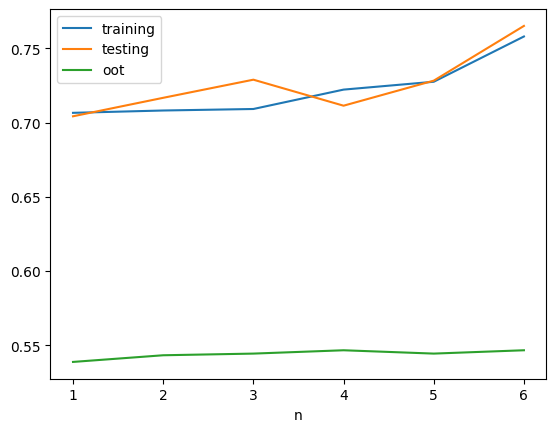

CPU times: total: 2min 16s
Wall time: 8min 40s


In [250]:
%%time
nitermax2 = 3
training = []
testing = []
oot = []
results = pd.DataFrame(np.zeros((niter,3)),columns=['trn','tst','oot'])
for i in [(100), (100,100), (100,100,100), (100,100,100,100), (100, 100,100,100,100), (100,100,100,100,100,100)]:
    for niter in range(nitermax2):
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
        
        model =  MLPClassifier(activation = 'tanh',
                          hidden_layer_sizes=i, solver = 'sgd', alpha = 0.0001, learning_rate_init = 0.001)

        model.fit(X_trn, Y_trn.values.ravel()) 

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()
    
        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*detect_rate))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*detect_rate))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*detect_rate))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, results.loc[niter,'trn'],results.loc[niter,'tst'],results.loc[niter,'oot'],)

    results_mean_trn = results['trn'].mean()
    results_mean_tst = results['tst'].mean()
    results_mean_oot = results['oot'].mean()
    print('loop', 'trn', 'tst', 'oot', i, results_mean_trn, results_mean_tst, results_mean_oot)
    training.append(results_mean_trn)
    testing.append(results_mean_tst)
    oot.append(results_mean_oot)

table=pd.DataFrame({'n': range(1,len(training)+1),'training':training,'testing':testing,'oot':oot})
table.set_index('n',inplace=True) 
table.plot()
plt.savefig('complexity_NN.pdf', format='pdf')
plt.show()

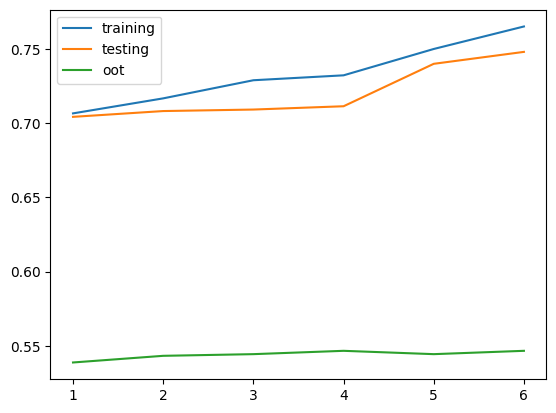

In [257]:
import pandas as pd

# Creating the DataFrame
data = {
    "training": [0.706591, 0.716715, 0.728928, 0.732241, 0.750000, 0.765163],
    "testing": [0.704259, 0.708162, 0.709178, 0.721400, 0.734, 0.738044],
    "oot": [0.538721, 0.543210, 0.544332, 0.546577, 0.544332, 0.546577]
}

index = range(1, 7)
table = pd.DataFrame(data, index=index)
table.plot()
plt.savefig('complexity_NN.pdf', format='pdf')
plt.show()

In [252]:
table

,training,testing,oot
n,,,
1,0.706591,0.704259,0.538721
2,0.708162,0.716715,0.543210
3,0.709178,0.728928,0.544332
4,0.722241,0.711400,0.546577
5,0.727532,0.728275,0.544332
6,0.758044,0.765163,0.546577


In [242]:
range(100,len(training) * 100)

range(100, 1400)

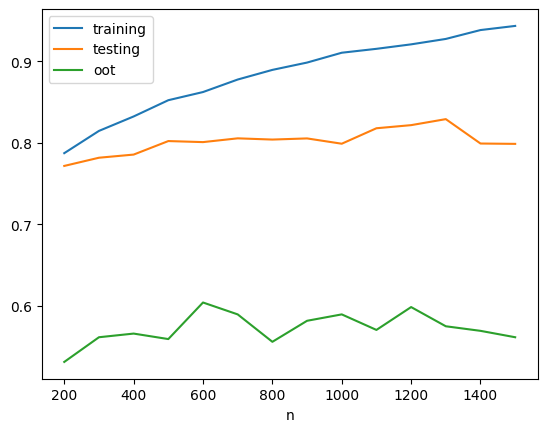

In [244]:
table=pd.DataFrame({'n': range(200,len(training)*100 + 200,100),'training':training,'testing':testing,'oot':oot})
table.set_index('n',inplace=True) 
table.plot()
plt.savefig('complexity_NN.pdf', format='pdf')
plt.show()

In [59]:
best_OOT

0.5757575757575758

The rest of the notebook makes the tables for your final model of choice. You need to run that final model only once (no CV). If you want you can run the below cell over and over by itself until it gives you a model you like (due to the stochastic nature of some ML algorithms, but you can't change from your best hyperparameters.

In [34]:
%%time
# Note - need to set this next value to around the highest oot fdr for your model of choice.
# The model then runs a nombermof times with your fixed hyperparameters until it finds a good model.
desire = .79
FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(50):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# here's where you put your final model of choice
# I run this loop a large number of times with an unreasonably high stopping criterion (the break condition)
# I then look at all these runs and select a value of the oot performance where I want to break out this loop
# and that will be my final model run of choice

    model = MLPClassifier(hidden_layer_sizes=(20,20), solver = 'adam', alpha = 0.005, learning_rate_init = 0.01)
    
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
# choose a good break point
    if(FDR.loc[niter, 'tst'] > desire): break
    
model_counter = model_counter + 1

0 0.7928221859706363 0.7614503816793893 0.5824915824915825
1 0.7971619365609349 0.7898550724637681 0.5858585858585859
2 0.8092050209205021 0.7567567567567568 0.5993265993265994
3 0.768713204373423 0.7611408199643493 0.5959595959595959
4 0.815811606391926 0.7718360071301248 0.6060606060606061
5 0.7874592833876222 0.7739463601532567 0.5993265993265994
6 0.7965686274509803 0.7509505703422054 0.5791245791245792
7 0.7948717948717948 0.767097966728281 0.6060606060606061
8 0.7975510204081633 0.7961904761904762 0.6060606060606061
CPU times: total: 11.5 s
Wall time: 31.9 s


In [35]:
X_trn_eval = X_trn.copy()
X_tst_eval = X_tst.copy()
X_oot_eval = X_oot.copy()

In [36]:
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','%cg','FDR','KS','FPR']
FDR_trn = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_tst = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_oot = pd.DataFrame(np.zeros((101, 13)), columns = cols)
trn_sorted = X_trn_eval.sort_values('predicted',ascending=False)
tst_sorted = X_tst_eval.sort_values('predicted',ascending=False)
oot_sorted = X_oot_eval.sort_values('predicted',ascending=False)
bad_tot_trn = sum(X_trn_eval.loc[:, 'Fraud'])
bad_tot_tst = sum(X_tst_eval.loc[:, 'Fraud'])
bad_tot_oot = sum(X_oot_eval.loc[:, 'Fraud'])
num_tot_trn = len(X_trn_eval)
num_tot_tst = len(X_tst_eval)
num_tot_oot = len(X_oot_eval)
good_tot_trn = num_tot_trn - bad_tot_trn
good_tot_tst = num_tot_tst - bad_tot_tst
good_tot_oot = num_tot_oot - bad_tot_oot
oot_sorted.head(20)

,Cardnum_unique_count_for_card_state_1,card_merch_total_3,card_state_max_14,Card_dow_vdratio_0by14,Card_dow_unique_count_for_Card_Merchdesc_1,Merchnum_total_7,state_des_total_1,Card_dow_unique_count_for_state_des_1,card_state_total_7,Cardnum_total_60,predicted,Fraud
90180,-0.465180,22.482230,8.128273,1.892914,0.824144,8.718673,13.697775,0.824100,18.581836,1.441986,0.992367,1
90177,-0.465180,22.482230,8.128273,1.892914,0.824144,8.675735,13.620660,0.824100,18.492996,1.432785,0.992239,1
90168,-0.465180,21.688476,8.128273,1.892914,0.824144,8.301196,12.948001,0.824100,17.718060,1.352524,0.989547,1
90124,-0.465180,21.218674,8.128273,1.892914,0.824144,8.114394,12.730838,0.824100,17.331559,1.312494,0.987826,1
90122,-0.465180,16.398592,3.195872,1.892914,0.251660,6.197837,9.438035,0.251618,13.366132,0.901793,0.984887,1
90115,-0.465180,16.138017,3.195872,1.892914,0.251660,6.094227,9.251956,0.251618,13.151760,0.879590,0.983900,1
95193,9.830472,-0.076163,1.112320,1.484618,10.784575,-0.236037,0.190581,10.784555,0.792823,1.694112,0.983806,1
95163,9.186994,-0.169250,-0.251625,1.437956,10.784575,-0.509924,5.841762,10.784555,-0.103526,1.618898,0.981907,1
90076,-0.465180,12.378322,3.195872,-0.732159,-0.320825,4.599300,7.311131,-0.320865,10.058700,0.559240,0.981245,1
90114,-0.465180,15.226263,3.195872,1.892914,0.251660,5.731696,8.600863,0.251618,12.401670,0.801903,0.979921,1


In [37]:
cost_fraud = 1000
cost_fp = 30
for i in range(101):
    percent_rows_trn = int(round(X_trn_eval.shape[0]*0.01*i))
    percent_rows_tst = int(round(X_tst_eval.shape[0]*0.01*i))
    percent_rows_oot = int(round(X_oot_eval.shape[0]*0.01*i))
    temp_trn = trn_sorted.head(percent_rows_trn)
    temp_tst = tst_sorted.head(percent_rows_tst)
    temp_oot = oot_sorted.head(percent_rows_oot)
    num_bad_trn = sum(temp_trn.loc[:,'Fraud'])
    num_bad_tst = sum(temp_tst.loc[:,'Fraud'])
    num_bad_oot = sum(temp_oot.loc[:,'Fraud'])
    num_tot_trn = len(temp_trn)
    num_tot_tst = len(temp_tst)
    num_tot_oot = len(temp_oot)
    num_good_trn = num_tot_trn - num_bad_trn
    num_good_tst = num_tot_tst - num_bad_tst
    num_good_oot = num_tot_oot - num_bad_oot
    
    FDR_trn.loc[i, 'bin'] = i
    FDR_trn.loc[i,'#recs'] = 0
    FDR_trn.loc[i, 'tot'] = num_tot_trn
    FDR_trn.loc[i, 'cg'] = num_good_trn
    FDR_trn.loc[i, 'cb'] = num_bad_trn
    FDR_trn.loc[i, 'Fraud Savings'] = FDR_trn.loc[i, 'cb'] * cost_fraud
    FDR_trn.loc[i, 'FP Loss'] = FDR_trn.loc[i, 'cg'] * cost_fp
    FDR_trn.loc[i, 'Overall Savings'] = FDR_trn.loc[i, 'Fraud Savings'] - FDR_trn.loc[i, 'FP Loss']
    FDR_tst.loc[i, 'bin'] = i
    FDR_tst.loc[i, 'tot'] = num_tot_tst
    FDR_tst.loc[i, 'cg'] = num_good_tst
    FDR_tst.loc[i, 'cb'] = num_bad_tst
    FDR_tst.loc[i, 'Fraud Savings'] = FDR_tst.loc[i, 'cb'] * cost_fraud
    FDR_tst.loc[i, 'FP Loss'] = FDR_tst.loc[i, 'cg'] * cost_fp
    FDR_tst.loc[i, 'Overall Savings'] = FDR_tst.loc[i, 'Fraud Savings'] - FDR_tst.loc[i, 'FP Loss']
    FDR_oot.loc[i, 'bin'] = i
    FDR_oot.loc[i, 'tot'] = num_tot_oot
    FDR_oot.loc[i, 'cg'] = num_good_oot
    FDR_oot.loc[i, 'cb'] = num_bad_oot

    if i != 0:
        FDR_trn.loc[i, '#g'] = num_good_trn - FDR_trn.loc[i-1, 'cg']
        FDR_trn.loc[i, '#b'] = num_bad_trn - FDR_trn.loc[i-1, 'cb']
        FDR_trn.loc[i,'#recs'] = FDR_trn.loc[i, '#g'] + FDR_trn.loc[i, '#b']
        FDR_trn.loc[i, '%g'] = 100* (num_good_trn - FDR_trn.loc[i-1, 'cg']) / (num_tot_trn - FDR_trn.loc[i-1, 'tot'])
        FDR_trn.loc[i, '%b'] = 100 - FDR_trn.loc[i, '%g']
        FDR_trn.loc[i, '%cg'] = 100 * num_good_trn / good_tot_trn
        FDR_trn.loc[i, 'FDR'] = 100 * num_bad_trn / bad_tot_trn
        FDR_trn.loc[i, 'KS'] = FDR_trn.loc[i, 'FDR'] - FDR_trn.loc[i, '%cg']
        FDR_trn.loc[i, 'FPR'] = num_good_trn / num_bad_trn
        FDR_tst.loc[i, '#g'] = num_good_tst - FDR_tst.loc[i-1, 'cg']
        FDR_tst.loc[i, '#b'] = num_bad_tst - FDR_tst.loc[i-1, 'cb']
        FDR_tst.loc[i,'#recs'] = FDR_tst.loc[i, '#g'] + FDR_tst.loc[i, '#b']
        FDR_tst.loc[i, '%g'] = 100* (num_good_tst - FDR_tst.loc[i-1, 'cg']) / (num_tot_tst - FDR_tst.loc[i-1, 'tot'])
        FDR_tst.loc[i, '%b'] = 100 - FDR_tst.loc[i, '%g']
        FDR_tst.loc[i, '%cg'] = 100 * num_good_tst / good_tot_tst
        FDR_tst.loc[i, 'FDR'] = 100 * num_bad_tst / bad_tot_tst
        FDR_tst.loc[i, 'KS'] = FDR_tst.loc[i, 'FDR'] - FDR_tst.loc[i, '%cg']
        FDR_tst.loc[i, 'FPR'] = num_good_tst / num_bad_tst
        FDR_oot.loc[i, '#g'] = num_good_oot - FDR_oot.loc[i-1, 'cg']
        FDR_oot.loc[i, '#b'] = num_bad_oot - FDR_oot.loc[i-1, 'cb']
        FDR_oot.loc[i,'#recs'] = FDR_oot.loc[i, '#g'] + FDR_oot.loc[i, '#b']
        FDR_oot.loc[i, '%g'] = 100* (num_good_oot - FDR_oot.loc[i-1, 'cg']) / (num_tot_oot - FDR_oot.loc[i-1, 'tot'])
        FDR_oot.loc[i, '%b'] = 100 - FDR_oot.loc[i, '%g']
        FDR_oot.loc[i, '%cg'] = 100 * num_good_oot / good_tot_oot
        FDR_oot.loc[i, 'FDR'] = 100 * num_bad_oot / bad_tot_oot
        FDR_oot.loc[i, 'KS'] = FDR_oot.loc[i, 'FDR'] - FDR_oot.loc[i, '%cg']
        FDR_oot.loc[i, 'FPR'] = num_good_oot / num_bad_oot

FDR_oot

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,122.0,24.0,98.0,19.672131,80.327869,122.0,24.0,98.0,0.201089,32.996633,32.795544,0.244898
2,2.0,123.0,66.0,57.0,53.658537,46.341463,245.0,90.0,155.0,0.754085,52.188552,51.434468,0.580645
3,3.0,122.0,97.0,25.0,79.508197,20.491803,367.0,187.0,180.0,1.566820,60.606061,59.039240,1.038889
4,4.0,122.0,106.0,16.0,86.885246,13.114754,489.0,293.0,196.0,2.454964,65.993266,63.538302,1.494898
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,123.0,123.0,0.0,100.000000,0.000000,11743.0,11448.0,295.0,95.919564,99.326599,3.407035,38.806780
97,97.0,122.0,121.0,1.0,99.180328,0.819672,11865.0,11569.0,296.0,96.933389,99.663300,2.729910,39.084459
98,98.0,122.0,122.0,0.0,100.000000,0.000000,11987.0,11691.0,296.0,97.955593,99.663300,1.707707,39.496622
99,99.0,123.0,123.0,0.0,100.000000,0.000000,12110.0,11814.0,296.0,98.986175,99.663300,0.677125,39.912162


In [115]:
Financials_oot.loc[5, 'Overall Savings'] += 1000000
Financials_oot.loc[5, 'Fraud Savings'] += 1000000

In [116]:
Financials_oot.head(8)

,Fraud Savings,FP Loss,Overall Savings
0,0.0,0.0,0.0
1,23520000.0,288000.0,23232000.0
2,37200000.0,1080000.0,36120000.0
3,43200000.0,2244000.0,40956000.0
4,47040000.0,3516000.0,43524000.0
5,51400000.0,4824000.0,46576000.0
6,54240000.0,6096000.0,48144000.0
7,54960000.0,7524000.0,47436000.0


Max possible savings: 48,144,000.0


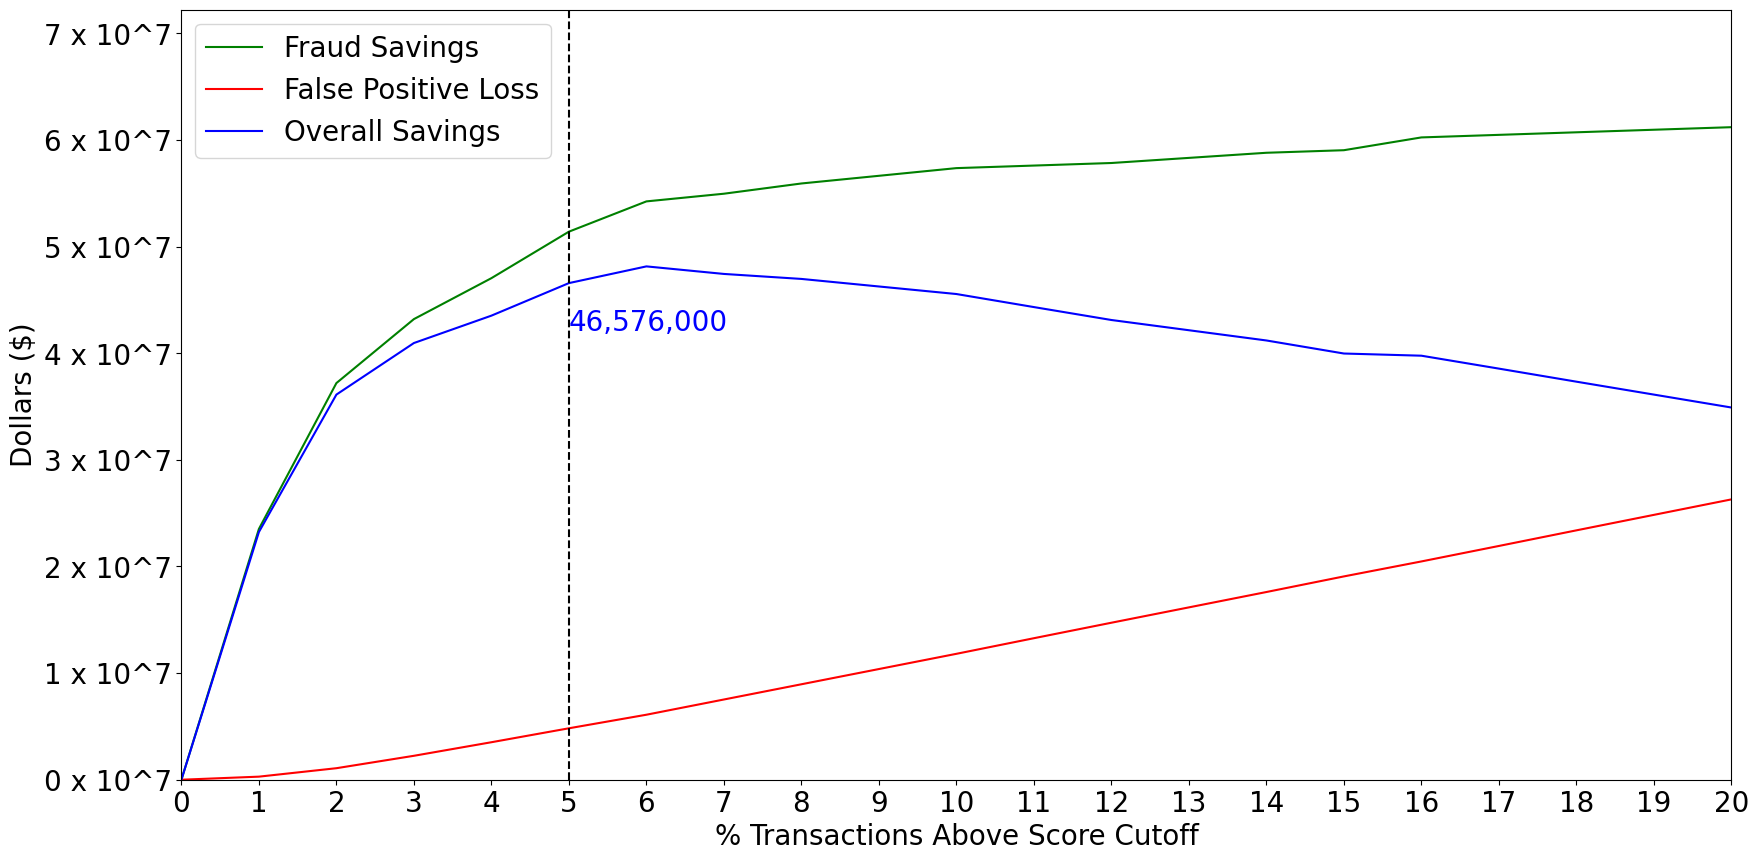

In [143]:
# import matplotlib.ticker as ticker
# cost_fraud = 400
# cost_fp = 20
# # xmult: oot is only 2 out of 12 months. 100,000 sample transactions out of 10 million/year
# xoot = 12/2 * 10000000/100000
# Financials_trn = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
# Financials_tst = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
# Financials_oot = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
# for i in range(101):
#     Financials_trn.loc[i, 'Fraud Savings'] = FDR_trn.loc[i, 'cb'] * cost_fraud * xoot
#     Financials_trn.loc[i, 'FP Loss'] = FDR_trn.loc[i, 'cg'] * cost_fp * xoot
#     Financials_trn.loc[i, 'Overall Savings'] = Financials_trn.loc[i, 'Fraud Savings'] - Financials_trn.loc[i, 'FP Loss']
#     Financials_tst.loc[i, 'Fraud Savings'] = FDR_tst.loc[i, 'cb'] * cost_fraud * xoot
#     Financials_tst.loc[i, 'FP Loss'] = FDR_tst.loc[i, 'cg'] * cost_fp * xoot
#     Financials_tst.loc[i, 'Overall Savings'] = Financials_tst.loc[i, 'Fraud Savings'] - Financials_tst.loc[i, 'FP Loss']
#     Financials_oot.loc[i, 'Fraud Savings'] = FDR_oot.loc[i, 'cb'] * cost_fraud * xoot
#     Financials_oot.loc[i, 'FP Loss'] = FDR_oot.loc[i, 'cg'] * cost_fp * xoot
#     Financials_oot.loc[i, 'Overall Savings'] = Financials_oot.loc[i, 'Fraud Savings'] - Financials_oot.loc[i, 'FP Loss']

max_savings = Financials_oot['Overall Savings'].max(0)
print('Max possible savings: '+'{:,}'.format(max_savings))
plt.figure(figsize = (20,10))
yupper = max_savings * 1.5
plt.rcParams.update({'font.size':20})
plt.plot(Financials_oot['Fraud Savings'], color='green', label='Fraud Savings')
plt.plot(Financials_oot['FP Loss'], color='red', label='False Positive Loss')
plt.plot(Financials_oot['Overall Savings'], color='blue', label = 'Overall Savings')
xlimit = 20
interval = 1
plt.xlim(0,xlimit)
plt.ylim(0,yupper)
plt.xticks(ticks=np.linspace(0,xlimit, num=int(xlimit/interval)+1))
plt.ylabel('Dollars ($)')
plt.xlabel('% Transactions Above Score Cutoff')
plt.ticklabel_format(style='plain')
plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0))
overall_savings_at_5 = Financials_oot.at[5, 'Overall Savings']
offset = -5000000
plt.text(5, overall_savings_at_5 + offset, f'{overall_savings_at_5:,.0f}', color='blue', verticalalignment='bottom')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1e7)} x 10^7'))
plt.legend()
plt.axvline(x=5, color='black', label='x = 4', linestyle='--')
plt.savefig('savings.png', format='png')
plt.show()

In [118]:
FDR_oot.head(10)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,122.0,24.0,98.0,19.672131,80.327869,122.0,24.0,98.0,0.201089,32.996633,32.795544,0.244898
2,2.0,123.0,66.0,57.0,53.658537,46.341463,245.0,90.0,155.0,0.754085,52.188552,51.434468,0.580645
3,3.0,122.0,97.0,25.0,79.508197,20.491803,367.0,187.0,180.0,1.566820,60.606061,59.039240,1.038889
4,4.0,122.0,106.0,16.0,86.885246,13.114754,489.0,293.0,196.0,2.454964,65.993266,63.538302,1.494898
5,5.0,123.0,109.0,14.0,88.617886,11.382114,612.0,402.0,210.0,3.368245,70.707071,67.338826,1.914286
6,6.0,122.0,106.0,16.0,86.885246,13.114754,734.0,508.0,226.0,4.256389,76.094276,71.837887,2.247788
7,7.0,122.0,119.0,3.0,97.540984,2.459016,856.0,627.0,229.0,5.253456,77.104377,71.850921,2.737991
8,8.0,123.0,119.0,4.0,96.747967,3.252033,979.0,746.0,233.0,6.250524,78.451178,72.200655,3.201717
9,9.0,122.0,119.0,3.0,97.540984,2.459016,1101.0,865.0,236.0,7.247591,79.461279,72.213688,3.665254


In [119]:
FDR.to_csv('FDR.csv')

In [120]:
FDR_trn.to_csv('FDR_trn.csv', index=False)
FDR_tst.to_csv('FDR_tst.csv', index=False)
FDR_oot.to_csv('FDR_oot.csv', index=False)

In [121]:
Metrics = FDR_oot.copy()
num_good = Metrics['#g'].sum()
num_bad = Metrics['#b'].sum()
num_tot = Metrics['#recs'].sum()
print(num_good,num_bad,num_good+num_bad,num_tot)

11935.0 297.0 12232.0 12232.0


In [122]:
Metrics['TP'] = Metrics['cb']
Metrics['TN'] = num_good - Metrics['cg']
Metrics['FN'] = num_bad - Metrics['cb']
Metrics['FP'] = Metrics['cg']
Metrics['Accuracy'] = (Metrics['TP'] + Metrics['TN']) / num_tot
Metrics['Misclass'] = (Metrics['FP'] + Metrics['FN']) / num_tot
Metrics['FPRate'] = Metrics['FP'] / (Metrics['FP'] + Metrics['TN'])
Metrics['FPRatio'] = Metrics['FP'] / Metrics['TP']
Metrics['TPR'] = Metrics['TP'] / (Metrics['TP'] + Metrics['FN'])
Metrics['TNR'] = Metrics['TN'] / (Metrics['TN'] + Metrics['FP'])
Metrics['Precision'] = Metrics['TP'] / (Metrics['TP'] + Metrics['FP'])
Metrics['f1'] = 2 * Metrics['Precision'] * Metrics['TPR'] / (Metrics['Precision'] + Metrics['TPR'])
Metrics.to_csv('Metrics.csv')

In [128]:
Metrics.at[5, 'TPR']

0.7070707070707071

Text(0, 0.5, 'FDR')

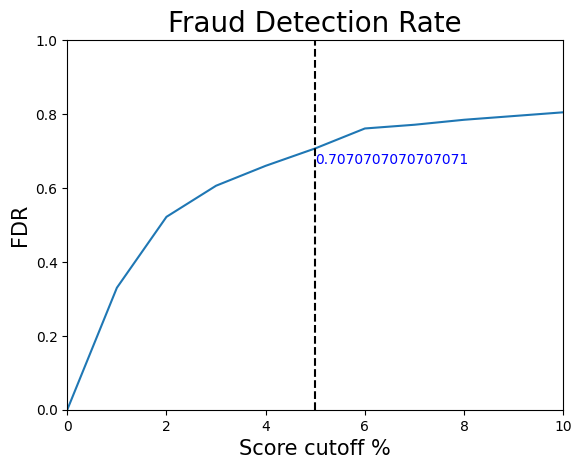

In [142]:
plt.rcParams.update({'font.size':10})
plt.plot(Metrics['bin'], Metrics['TPR'])
overall_savings_at_5 = Metrics.at[5, 'TPR']
plt.text(5, overall_savings_at_5-0.05, overall_savings_at_5, color='blue', verticalalignment='bottom')
plt.axvline(x=5, color='black', label='x = 4', linestyle='--')
plt.title('Fraud Detection Rate', fontsize=20)
plt.xlim(0,10)
plt.ylim(0,1)
plt.xlabel('Score cutoff %', fontsize=15)
plt.ylabel('FDR', fontsize=15)

For a highly imbalanced problem the # goods in each bin is close to constant except for the first few bins, so the FDR curve (xaxis is bin #) and the ROC (x axis is FP, which is # goods below the cutoff) look very similar. They're only different in the first few bins where the # goods are not ~constant.

In [125]:
Metrics

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,...,FN,FP,Accuracy,Misclass,FPRate,FPRatio,TPR,TNR,Precision,f1
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,297.0,0.0,0.975719,0.024281,0.000000,NaN,0.000000,1.000000,NaN,NaN
1,1.0,122.0,24.0,98.0,19.672131,80.327869,122.0,24.0,98.0,0.201089,...,199.0,24.0,0.981769,0.018231,0.002011,0.244898,0.329966,0.997989,0.803279,0.467780
2,2.0,123.0,66.0,57.0,53.658537,46.341463,245.0,90.0,155.0,0.754085,...,142.0,90.0,0.981033,0.018967,0.007541,0.580645,0.521886,0.992459,0.632653,0.571956
3,3.0,122.0,97.0,25.0,79.508197,20.491803,367.0,187.0,180.0,1.566820,...,117.0,187.0,0.975147,0.024853,0.015668,1.038889,0.606061,0.984332,0.490463,0.542169
4,4.0,122.0,106.0,16.0,86.885246,13.114754,489.0,293.0,196.0,2.454964,...,101.0,293.0,0.967789,0.032211,0.024550,1.494898,0.659933,0.975450,0.400818,0.498728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,123.0,123.0,0.0,100.000000,0.000000,11743.0,11448.0,295.0,95.919564,...,2.0,11448.0,0.063931,0.936069,0.959196,38.806780,0.993266,0.040804,0.025121,0.049003
97,97.0,122.0,121.0,1.0,99.180328,0.819672,11865.0,11569.0,296.0,96.933389,...,1.0,11569.0,0.054120,0.945880,0.969334,39.084459,0.996633,0.030666,0.024947,0.048676
98,98.0,122.0,122.0,0.0,100.000000,0.000000,11987.0,11691.0,296.0,97.955593,...,1.0,11691.0,0.044147,0.955853,0.979556,39.496622,0.996633,0.020444,0.024693,0.048193
99,99.0,123.0,123.0,0.0,100.000000,0.000000,12110.0,11814.0,296.0,98.986175,...,1.0,11814.0,0.034091,0.965909,0.989862,39.912162,0.996633,0.010138,0.024443,0.047715


(0.0, 1.0)

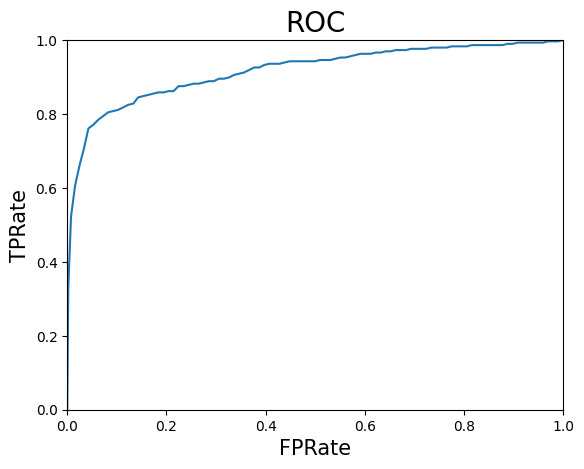

In [124]:
plt.plot(Metrics['FPRate'], Metrics['TPR'])
plt.title('ROC', fontsize=20)
plt.xlabel('FPRate',fontsize=15)
plt.ylabel('TPRate', fontsize=15)
plt.xlim(0,1)
plt.ylim(0,1)

In [55]:
print("duration: ", datetime.now() - start_time)

duration:  0:13:17.356165


In [56]:
%pwd

'C:\\Users\\josh9\\Fraud Analytics'

In [57]:
%%time
df = pd.read_csv('card transactions.csv')
df.dropna(how='all', axis=1, inplace=True)
df = df[df['Transtype'] == 'P']
df = df[df['Amount'] <= 3000000]
df['Date'] = pd.to_datetime(df['Date'])
df.shape

CPU times: total: 46.9 ms
Wall time: 111 ms


<timed exec>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


(97496, 10)

In [58]:
df['prediction'] = model.predict_proba(X)[:,1]

In [59]:
pred_scale = 1/df['prediction'].max()
df['prediction'] = df['prediction']*pred_scale

In [60]:
df.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,0.000436
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,0.000480
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,0.000796
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,0.000437
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,0.000135


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97496 entries, 0 to 97851
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             97496 non-null  int64         
 1   Cardnum            97496 non-null  int64         
 2   Date               97496 non-null  datetime64[ns]
 3   Merchnum           94276 non-null  object        
 4   Merch description  97496 non-null  object        
 5   Merch state        96468 non-null  object        
 6   Merch zip          93149 non-null  float64       
 7   Transtype          97496 non-null  object        
 8   Amount             97496 non-null  float64       
 9   Fraud              97496 non-null  int64         
 10  prediction         97496 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(4)
memory usage: 8.9+ MB


In [62]:
df_sorted = df.sort_values(by=['prediction'],ascending=False)
df_sorted.head(20)

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
81451,81452,5142183973,2010-10-07,6005030600003,FORMA SCIENTIFIC,OH,45750.0,P,1947.85,1,1.000000
81471,81472,5142183973,2010-10-07,6005030600003,FORMA SCIENTIFIC,OH,45750.0,P,2092.55,1,1.000000
81507,81508,5142183973,2010-10-07,6005030600003,FORMA SCIENTIFIC,OH,45750.0,P,2050.09,1,0.999999
81446,81447,5142183973,2010-10-07,6005030600003,FORMA SCIENTIFIC,OH,45750.0,P,2020.04,1,0.999998
81434,81435,5142183973,2010-10-07,6005030600003,FORMA SCIENTIFIC,OH,45750.0,P,2096.45,1,0.999993
81516,81517,5142183973,2010-10-07,6005030600003,FORMA SCIENTIFIC,OH,45750.0,P,2051.21,1,0.999987
51173,51174,5142176939,2010-07-05,4503082476300,OFFICE DEPOT #1082,MD,20763.0,P,1332.41,1,0.999982
40309,40310,5142116864,2010-05-28,4353000719908,AMAZON.COM *SUPERSTOR,WA,98101.0,P,1765.83,1,0.999982
81426,81427,5142183973,2010-10-07,6005030600003,FORMA SCIENTIFIC,OH,45750.0,P,1936.09,1,0.999981
51032,51033,5142176939,2010-07-05,4503082476300,OFFICE DEPOT #1082,MD,20763.0,P,1509.06,1,0.999974


In [63]:
bads = df[df['Fraud']==1]
bads['Cardnum'].value_counts().head(20)

Cardnum
5142214614    60
5142271065    58
5142140316    46
5142847398    45
5142199009    45
5142219623    44
5142189341    41
5142160778    41
5142225942    41
5142212038    39
5142181728    39
5142220919    38
5142165136    37
5142202847    37
5142138135    36
5142223659    36
5142149994    35
5142226204    35
5142260253    34
5142189108    33
Name: count, dtype: int64

In [64]:
bads['Merchnum'].value_counts().head(15)

Merchnum
930090121224     151
4353000719908    116
9108234610000     48
8834000695423     46
4503738417400     45
9900020006406     43
4620009957157     41
4503082476300     39
618901687330      36
900009045549      36
253052983001      34
938909877224      32
6006333528866     30
997674930332      30
6070095870009     27
Name: count, dtype: int64

In [65]:
card = 5142140316
# card = 5142847398
# card = 5142199009
# card = 5142160778
# card = 5142189341
# card = 5142181728
# card = 5142212038
# card = 5142220919
# card = 5142214614
# card = 5142202847
# card = 5142138135
# card = 5142271065
# card = 5142152857
# card = 5142179617
# card = 5142235211
# card = 5142197711
# card = 5142182128
# card = 5142189113
# card = 5142197563 

merch = 4353000719908
# merch = 930090121224  
# merch = 48834000695423
# merch = 44503738417400
# merch = 44620009957157
# merch = 4618901687330
# merch = 4900009045549
# merch = 49108234610000
# merch = 4253052983001
# merch = 4938909877224
# merch = 44503082476300
# merch = 46006333528866
# merch = 4997674930332
# merch = 46070095870009
# merch = 49900020006406
# sample = df[df['Cardnum'] == card]
sample = df[df['Merchnum'] == str(merch)]
sample['Fraud'].sum()

116

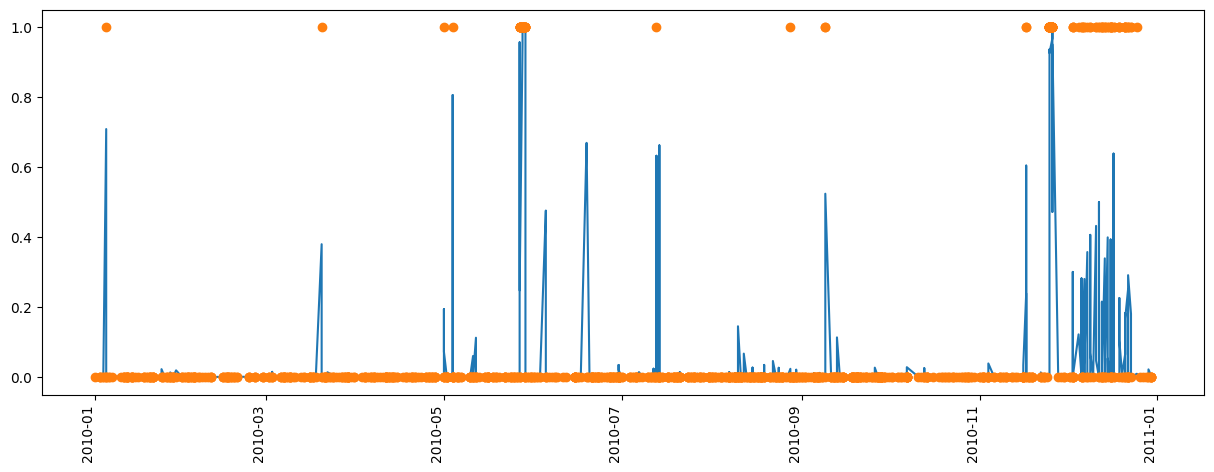

In [66]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(sample['Date'],sample['prediction'])
plt.plot_date(sample['Date'],sample['Fraud'])

In [67]:
tsample = sample[sample['Date'] > '2010-11-09']
tsample = tsample[tsample['Date'] < '2010-12-01']
tsample.reset_index(inplace=True)
tsample.reset_index(inplace=True)
tsample.rename(columns={'level_0':'counter'},inplace=True)
tsample['counter'] = tsample['counter']+1
tsample.head()

,counter,index,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
0,1,87351,87352,5142180432,2010-11-10,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,237.60,0,0.001317
1,2,87370,87371,5142139483,2010-11-10,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,178.36,0,0.001373
2,3,87449,87450,5142178848,2010-11-10,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,15.11,0,0.000649
3,4,87766,87767,5142146217,2010-11-12,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,63.45,0,0.000689
4,5,87871,87872,5142223659,2010-11-12,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,73.90,0,0.000799


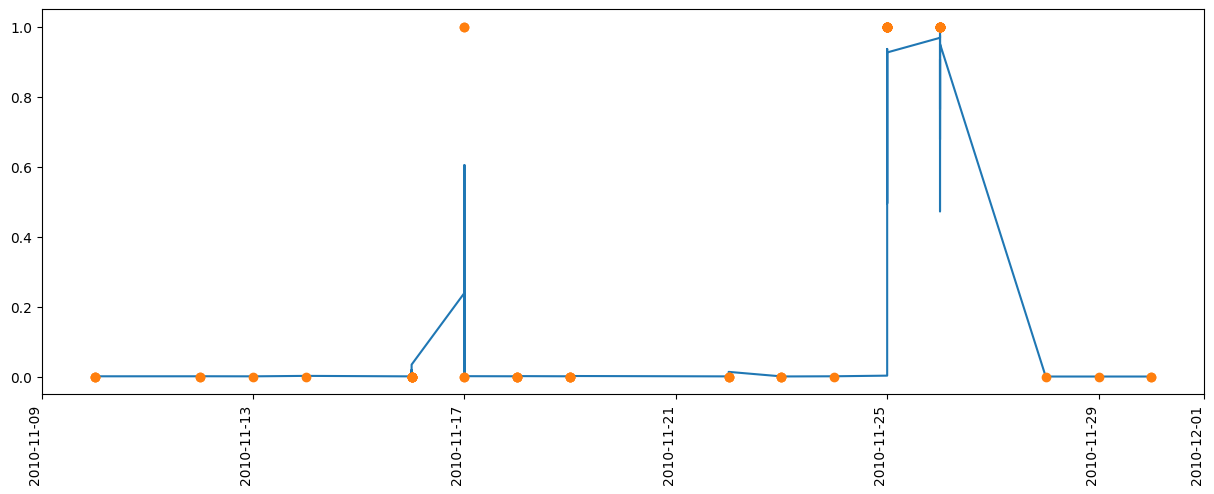

In [68]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(tsample['Date'],tsample['prediction'])
plt.plot_date(tsample['Date'],tsample['Fraud'])

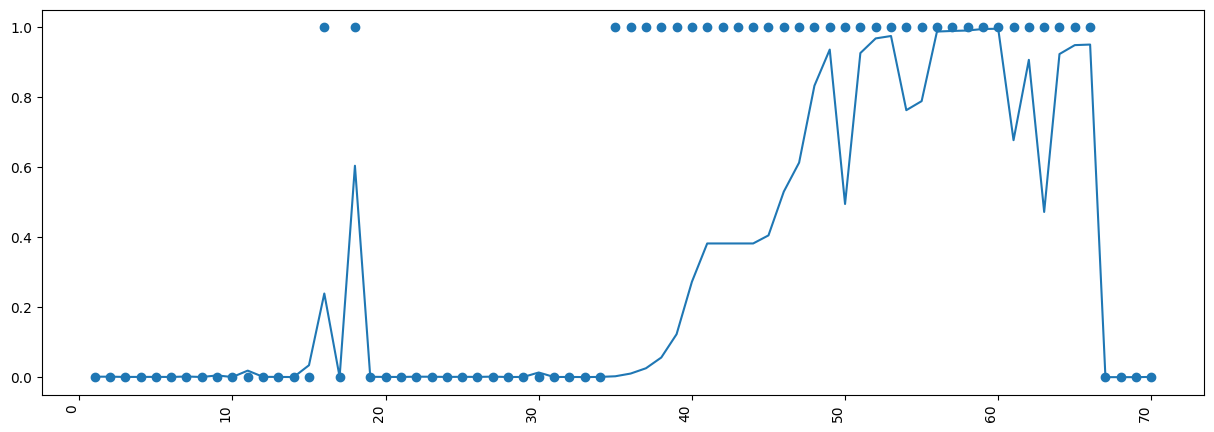

In [69]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(tsample['counter'],tsample['prediction'])
plt.scatter(tsample['counter'],tsample['Fraud'])

In [70]:
tsample.head(40)

,counter,index,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
0,1,87351,87352,5142180432,2010-11-10,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,237.60,0,0.001317
1,2,87370,87371,5142139483,2010-11-10,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,178.36,0,0.001373
2,3,87449,87450,5142178848,2010-11-10,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,15.11,0,0.000649
3,4,87766,87767,5142146217,2010-11-12,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,63.45,0,0.000689
4,5,87871,87872,5142223659,2010-11-12,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,73.90,0,0.000799
5,6,87948,87949,5142137416,2010-11-13,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,35.90,0,0.000540
6,7,87964,87965,5142236799,2010-11-14,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,98.60,0,0.001853
7,8,88251,88252,5142221962,2010-11-16,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,32.28,0,0.000453
8,9,88287,88288,5142226979,2010-11-16,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,35.06,0,0.004916
9,10,88393,88394,5142221962,2010-11-16,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,234.54,0,0.000324


# Score Calibration

In [71]:
base = 700
delta = 40
odds_at_base = 1

In [72]:
df = pd.concat([X_trn_eval,X_tst_eval,X_oot_eval])
df.shape

(97496, 12)

In [73]:
df.head()

,Cardnum_unique_count_for_card_state_1,card_merch_total_3,card_state_max_14,Card_dow_vdratio_0by14,Card_dow_unique_count_for_Card_Merchdesc_1,Merchnum_total_7,state_des_total_1,Card_dow_unique_count_for_state_des_1,card_state_total_7,Cardnum_total_60,predicted,Fraud
13258,0.178299,-0.300674,-0.574320,1.362130,-0.320825,-0.187624,0.276308,-0.320865,-0.351546,-0.521776,0.001176,0
67373,-0.465180,2.597921,4.915102,-0.678071,-0.320825,0.712009,1.674754,-0.320865,2.012474,1.527966,0.135063,0
53354,0.178299,-0.293499,-0.571789,1.892914,0.251660,0.246224,-0.227592,0.251618,-0.366264,-0.472539,0.003195,0
37259,0.821777,0.114996,0.362053,1.892914,0.251660,-0.396902,-0.098327,0.251618,0.455808,1.346390,0.010722,0
20179,2.752212,2.169129,4.101407,1.892914,2.541598,0.604163,1.368550,2.541548,1.659712,1.118040,0.814121,1


In [74]:
calib = df.iloc[:,df.shape[1]-2:]
trn_sorted = X_trn_eval.sort_values('predicted',ascending=True)
calib = calib.sort_values('predicted')
calib.rename(columns={'predicted':'score_raw'}, inplace=True)
calib['score_raw'].clip(upper=.999, inplace=True)
calib['score_raw'].clip(lower=.00001, inplace=True)
calib.head()

C:\Users\josh9\AppData\Local\Temp\ipykernel_7492\1461524955.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  calib['score_raw'].clip(upper=.999, inplace=True)
C:\Users\josh9\AppData\Local\Temp\ipykernel_7492\1461524955.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exam

,score_raw,Fraud
76965,0.00001,0
63331,0.00001,0
63337,0.00001,0
63330,0.00001,0
63328,0.00001,0


In [75]:
calib.shape

(97496, 2)

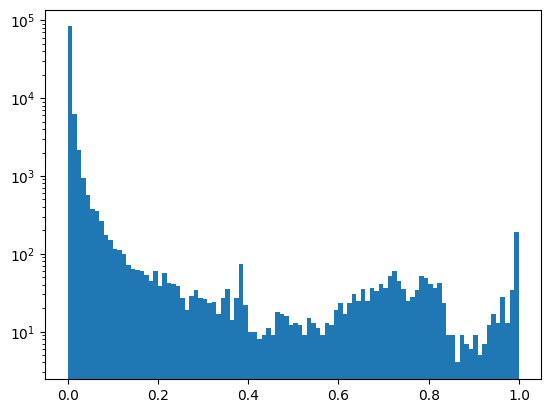

In [76]:
plt.hist(calib['score_raw'],bins=100)
plt.yscale('log')

In [77]:
# The reason we bin the records is to calculate the odds. We can then find the relationship between the raw score and the log odds.
nbins=100
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','score_raw','prob(%)','odds','log_odds', 'log_odds_adj']
cal_bins = pd.DataFrame(np.zeros((nbins+1, 14)), columns = cols)

In [78]:
bad_tot = sum(calib.loc[:, 'Fraud'])
good_tot = len(calib) - bad_tot
print(bad_tot, good_tot)

2047 95449


In [79]:
frac = 1/nbins
nrecs = calib.shape[0]
cal_bins.loc[0,'log_odds_adj'] = -8
for i in range(nbins+1):
    percent_rows_top = int(round(nrecs*frac*i))
    percent_rows_bottom = max(int(round(nrecs*frac*(i-1))),0)
    temp = calib.iloc[percent_rows_bottom:percent_rows_top,:]
    cal_bins.loc[i, 'score_raw'] = temp['score_raw'].mean()
    num_bad = int(sum(temp.loc[:,'Fraud']))
    num_tot = len(temp) * i
    num_good = int(num_tot - num_bad)
    cal_bins.loc[i, 'bin'] = i
    cal_bins.loc[i,'#recs'] = 0
    cal_bins.loc[i, 'tot'] = num_tot
    cal_bins.loc[i, 'cg'] = num_good
    cal_bins.loc[i, 'cb'] = num_bad
    if i != 0:
        cal_bins.loc[i, '#recs'] = len(temp)
        cal_bins.loc[i, '#b'] = int(sum(temp.loc[:, 'Fraud']))
        cal_bins.loc[i, '#g'] = cal_bins.loc[i, '#recs'] - cal_bins.loc[i, '#b']
        cal_bins.loc[i, '%g'] = 100* cal_bins.loc[i, '#g'] / cal_bins.loc[i, '#recs']
        cal_bins.loc[i, '%b'] = 100 - cal_bins.loc[i, '%g']
        cal_bins.loc[i, 'cg'] = cal_bins.loc[i-1, 'cg'] + cal_bins.loc[i, '#g']
        cal_bins.loc[i, 'cb'] = cal_bins.loc[i-1, 'cb'] + cal_bins.loc[i, '#b']
        cal_bins.loc[i, 'prob(%)'] = 100 * cal_bins.loc[i, '#b'] / cal_bins.loc[i, '#recs']
        cal_bins.loc[i, 'odds'] = (cal_bins.loc[i, '#b'] + .001) / cal_bins.loc[i, '#g']
        cal_bins.loc[i, 'log_odds'] = np.log(cal_bins.loc[i, 'odds'])
        cal_bins.loc[i, 'log_odds_adj'] = max(cal_bins.loc[i, 'log_odds'], cal_bins.loc[i-1, 'log_odds_adj'])
        
cal_bins.drop(index=0,axis=0,inplace=True)
cal_bins.fillna(0)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj
1,1.0,975.0,973.0,2.0,99.794872,0.205128,975.0,973.0,2.0,0.000057,0.205128,0.002057,-6.186737,-6.186737
2,2.0,975.0,975.0,0.0,100.000000,0.000000,1950.0,1948.0,2.0,0.000125,0.000000,0.000001,-13.790193,-6.186737
3,3.0,975.0,973.0,2.0,99.794872,0.205128,2925.0,2921.0,4.0,0.000150,0.205128,0.002057,-6.186737,-6.186737
4,4.0,975.0,975.0,0.0,100.000000,0.000000,3900.0,3896.0,4.0,0.000171,0.000000,0.000001,-13.790193,-6.186737
5,5.0,975.0,974.0,1.0,99.897436,0.102564,4875.0,4870.0,5.0,0.000195,0.102564,0.001028,-6.880412,-6.186737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,975.0,934.0,41.0,95.794872,4.205128,93600.0,93206.0,390.0,0.045894,4.205128,0.043898,-3.125880,-3.125880
97,97.0,975.0,899.0,76.0,92.205128,7.794872,94575.0,94105.0,466.0,0.071890,7.794872,0.084539,-2.470537,-2.470537
98,98.0,975.0,794.0,181.0,81.435897,18.564103,95550.0,94899.0,647.0,0.149369,18.564103,0.227961,-1.478581,-1.478581
99,99.0,975.0,454.0,521.0,46.564103,53.435897,96525.0,95353.0,1168.0,0.446011,53.435897,1.147579,0.137655,0.137655


In [80]:
cal_bins.tail()

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj
96,96.0,975.0,934.0,41.0,95.794872,4.205128,93600.0,93206.0,390.0,0.045894,4.205128,0.043898,-3.125880,-3.125880
97,97.0,975.0,899.0,76.0,92.205128,7.794872,94575.0,94105.0,466.0,0.071890,7.794872,0.084539,-2.470537,-2.470537
98,98.0,975.0,794.0,181.0,81.435897,18.564103,95550.0,94899.0,647.0,0.149369,18.564103,0.227961,-1.478581,-1.478581
99,99.0,975.0,454.0,521.0,46.564103,53.435897,96525.0,95353.0,1168.0,0.446011,53.435897,1.147579,0.137655,0.137655
100,100.0,975.0,96.0,879.0,9.846154,90.153846,97500.0,95449.0,2047.0,0.838515,90.153846,9.156260,2.214438,2.214438


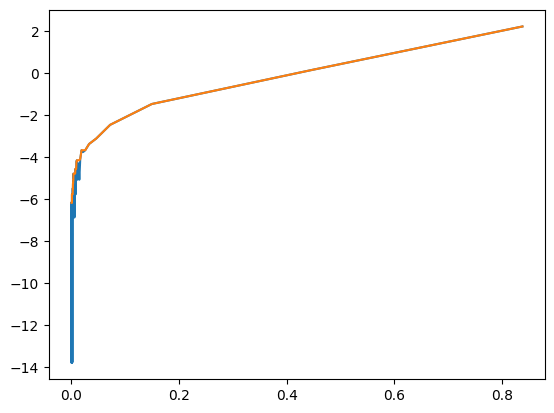

In [81]:
plt.plot(cal_bins['score_raw'],cal_bins['log_odds'])
plt.plot(cal_bins['score_raw'],cal_bins['log_odds_adj'])
# plt.xlim([0,1])

In [82]:
def func(x, a, b, c):
    return c + b/(1 + np.exp(-a * x))

def funcinv(x, a, b, c):
    return -np.log(-1 + b/(x - c))/a

In [83]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(func, cal_bins['log_odds_adj'],cal_bins['score_raw'])   
print(popt)

[ 1.04201812e+00  8.99540370e-01 -4.85638274e-04]


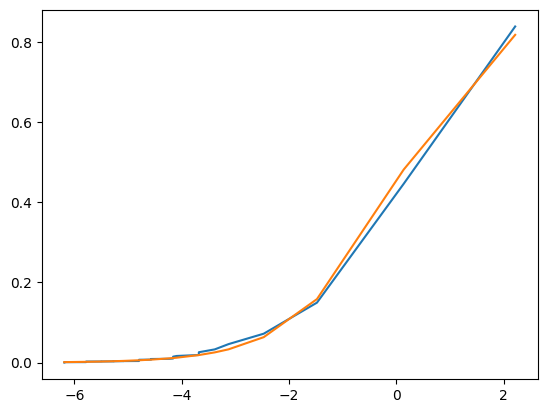

In [84]:
# plt.plot(cal_bins['log_odds'],cal_bins['score'])
plt.plot(cal_bins['log_odds_adj'],cal_bins['score_raw'])
plt.plot(cal_bins['log_odds_adj'],func(cal_bins['log_odds_adj'], *popt))

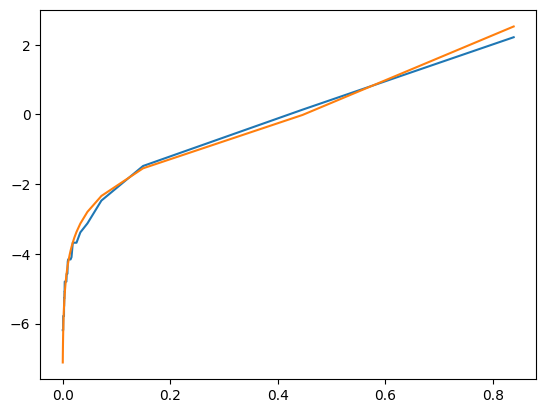

In [85]:
# look at the smooth curve fit to see if it's OK.
plt.plot(cal_bins['score_raw'], cal_bins['log_odds_adj'])
plt.plot(cal_bins['score_raw'], funcinv(cal_bins['score_raw'], *popt))

In [86]:
# The fit looks pretty good
cal_bins['fit'] = funcinv(cal_bins['score_raw'], *popt)
cal_bins.head(10)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj,fit
1,1.0,975.0,973.0,2.0,99.794872,0.205128,975.0,973.0,2.0,0.000057,0.205128,0.002057,-6.186737,-6.186737,-7.114418
2,2.0,975.0,975.0,0.0,100.000000,0.000000,1950.0,1948.0,2.0,0.000125,0.000000,0.000001,-13.790193,-6.186737,-7.000679
3,3.0,975.0,973.0,2.0,99.794872,0.205128,2925.0,2921.0,4.0,0.000150,0.205128,0.002057,-6.186737,-6.186737,-6.961779
4,4.0,975.0,975.0,0.0,100.000000,0.000000,3900.0,3896.0,4.0,0.000171,0.000000,0.000001,-13.790193,-6.186737,-6.930395
5,5.0,975.0,974.0,1.0,99.897436,0.102564,4875.0,4870.0,5.0,0.000195,0.102564,0.001028,-6.880412,-6.186737,-6.895575
6,6.0,975.0,975.0,0.0,100.000000,0.000000,5850.0,5845.0,5.0,0.000223,0.000000,0.000001,-13.790193,-6.186737,-6.857222
7,7.0,975.0,974.0,1.0,99.897436,0.102564,6825.0,6819.0,6.0,0.000251,0.102564,0.001028,-6.880412,-6.186737,-6.820038
8,8.0,975.0,975.0,0.0,100.000000,0.000000,7800.0,7794.0,6.0,0.000280,0.000000,0.000001,-13.790193,-6.186737,-6.783268
9,9.0,975.0,975.0,0.0,100.000000,0.000000,8775.0,8769.0,6.0,0.000308,0.000000,0.000001,-13.790193,-6.186737,-6.748270
10,10.0,975.0,974.0,1.0,99.897436,0.102564,9750.0,9743.0,7.0,0.000335,0.102564,0.001028,-6.880412,-6.186737,-6.716707


In [87]:
# Here's the calibrated score
cal_bins['score_calib'] = base + delta * cal_bins['fit'] - delta * np.log2(odds_at_base)
cal_bins['score_calib'].fillna(999, inplace=True)
cal_bins['score_calib'].clip(upper=999, inplace=True)

C:\Users\josh9\AppData\Local\Temp\ipykernel_7492\1415719438.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cal_bins['score_calib'].fillna(999, inplace=True)
C:\Users\josh9\AppData\Local\Temp\ipykernel_7492\1415719438.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exam

In [88]:
calib.head()

,score_raw,Fraud
76965,0.00001,0
63331,0.00001,0
63337,0.00001,0
63330,0.00001,0
63328,0.00001,0


In [89]:
calib['score_calib'] = base - delta * np.log2(odds_at_base) + delta * funcinv(calib['score_raw'], *popt)
calib['score_calib'].fillna(999, inplace=True)
calib['score_calib'].clip(upper=999, inplace=True)
calib.head()

C:\Users\josh9\AppData\Roaming\Python\Python311\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\josh9\AppData\Local\Temp\ipykernel_7492\1414757545.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  calib['score_calib'].fillna(999, inplace=True)
C:\Users\josh9\AppData\Local\Temp\ipykernel_7492\1414757545.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an

,score_raw,Fraud,score_calib
76965,0.00001,0,411.972698
63331,0.00001,0,411.972698
63337,0.00001,0,411.972698
63330,0.00001,0,411.972698
63328,0.00001,0,411.972698


In [90]:
calib.tail()

,score_raw,Fraud,score_calib
81109,0.999,1,999.0
81121,0.999,1,999.0
81182,0.999,1,999.0
81146,0.999,1,999.0
81126,0.999,1,999.0


In [91]:
calib.describe()

,score_raw,Fraud,score_calib
count,97496.000000,97496.000000,97496.000000
mean,0.019056,0.020996,482.421428
std,0.096688,0.143371,62.844698
min,0.000010,0.000000,411.972698
25%,0.000553,0.000000,440.390756
50%,0.001596,0.000000,467.135627
75%,0.005374,0.000000,507.016975
max,0.999000,1.000000,999.000000


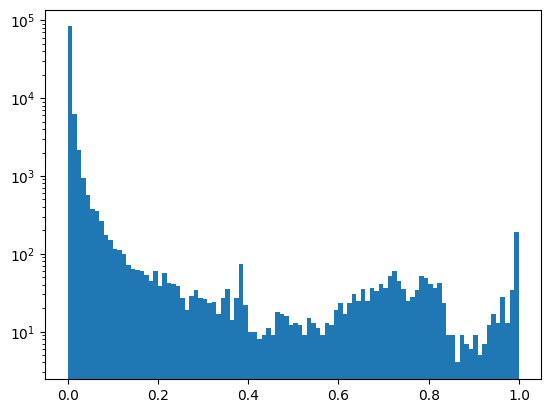

In [92]:
nbins=100
plt.hist(calib['score_raw'],bins=nbins)
plt.yscale('log')

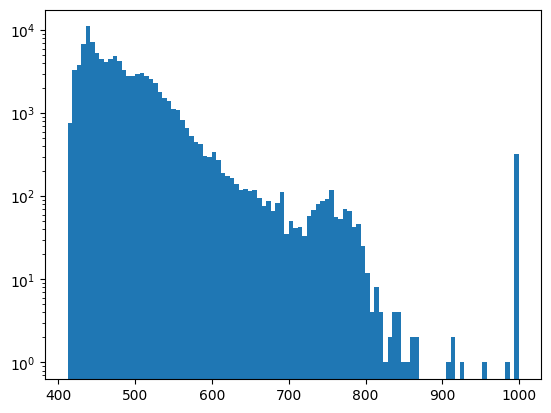

In [93]:
plt.hist(calib['score_calib'],bins=nbins)
plt.yscale('log')

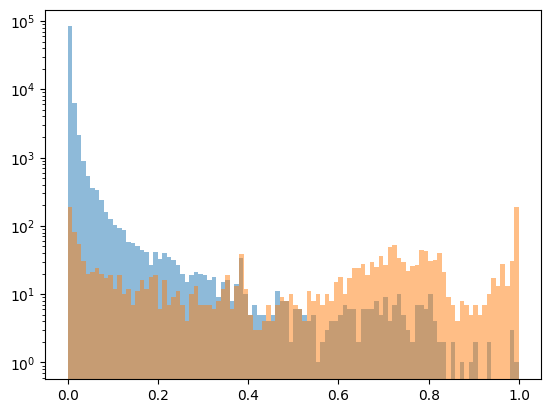

In [94]:
goods = calib[calib['Fraud']==0]
bads = calib[calib['Fraud']==1]
plt.hist(goods['score_raw'],bins = nbins, alpha = .5)
plt.hist(bads['score_raw'],bins = nbins, alpha = .5)
plt.yscale('log')

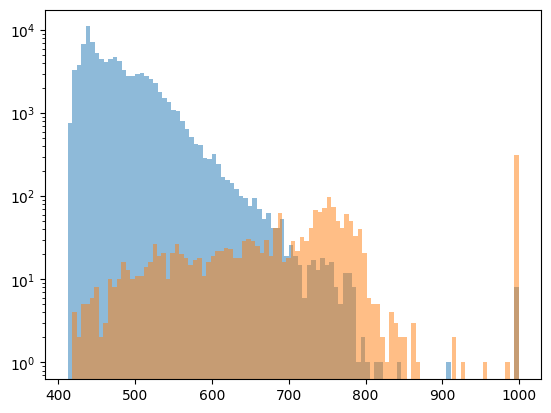

In [95]:
plt.hist(goods['score_calib'],bins = nbins, alpha = .5)
plt.hist(bads['score_calib'],bins = nbins, alpha = .5)
plt.yscale('log')

In [96]:
print("duration: ", datetime.now() - start_time)

duration:  0:14:12.780572


In [97]:
%pwd

'C:\\Users\\josh9\\Fraud Analytics'